Initial Grid:
[[2 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1]
 [1 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1]
 [0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0]
 [0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0]
 [1 0 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1]
 [0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1]
 [0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 3]]

Path Found:
[[2 4 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1]
 [1 4 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1]
 [0 4 1 0 0 0 0 1 1 0 0 0 

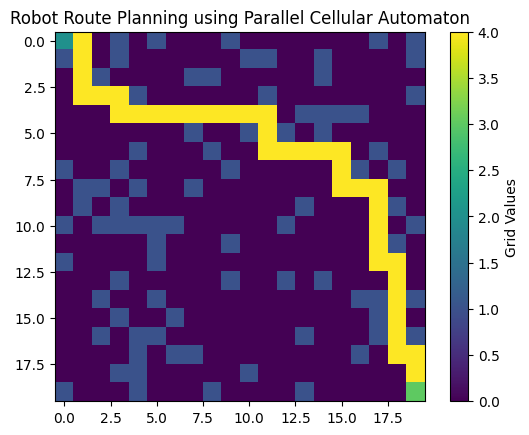

In [ ]:
import numpy as np
import multiprocessing as mp
import matplotlib.pyplot as plt

# Define grid environment
FREE = 0     # Free space
OBSTACLE = 1 # Obstacle
START = 2    # Start point
TARGET = 3   # Target point
PATH = 4     # Path found

# Generate grid environment
def create_grid(rows, cols, obstacle_ratio=0.2):
    grid = np.random.choice([FREE, OBSTACLE], size=(rows, cols), p=[1-obstacle_ratio, obstacle_ratio])
    grid[0, 0] = START          # Start point
    grid[-1, -1] = TARGET       # Target point
    return grid

# Define the cellular automaton rules
def update_cell(grid, cost_grid, row, col):
    if grid[row, col] == OBSTACLE or grid[row, col] == START:
        return cost_grid[row, col]  # No update for obstacles and start

    neighbors = [
        cost_grid[row-1, col] if row > 0 else np.inf,            # Up
        cost_grid[row+1, col] if row < grid.shape[0]-1 else np.inf,  # Down
        cost_grid[row, col-1] if col > 0 else np.inf,            # Left
        cost_grid[row, col+1] if col < grid.shape[1]-1 else np.inf  # Right
    ]
    return min(neighbors) + 1 if grid[row, col] != OBSTACLE else np.inf

# Parallel function for cost update
def parallel_update(grid, cost_grid):
    rows, cols = grid.shape
    new_cost_grid = cost_grid.copy()
    pool = mp.Pool(mp.cpu_count())

    tasks = [(grid, cost_grid, r, c) for r in range(rows) for c in range(cols)]
    results = pool.starmap(update_cell, tasks)

    # Update cost grid
    for idx, (r, c) in enumerate([(r, c) for r in range(rows) for c in range(cols)]):
        new_cost_grid[r, c] = results[idx]

    pool.close()
    pool.join()
    return new_cost_grid

# Backtrack to find the path
def backtrack_path(grid, cost_grid, start, target):
    path = []
    current = target
    while current != start:
        path.append(current)
        row, col = current
        neighbors = [
            ((row-1, col), cost_grid[row-1, col]) if row > 0 else (None, np.inf),
            ((row+1, col), cost_grid[row+1, col]) if row < grid.shape[0]-1 else (None, np.inf),
            ((row, col-1), cost_grid[row, col-1]) if col > 0 else (None, np.inf),
            ((row, col+1), cost_grid[row, col+1]) if col < grid.shape[1]-1 else (None, np.inf)
        ]
        next_cell = min(neighbors, key=lambda x: x[1])
        if next_cell[0] is None or next_cell[1] == np.inf:
            raise ValueError("No path found!")
        current = next_cell[0]

    path.append(start)
    return path[::-1]

# Main function to execute the route planning
def main():
    rows, cols = 20, 20  # Grid size
    grid = create_grid(rows, cols)

    # Initialize cost grid
    cost_grid = np.full_like(grid, np.inf, dtype=float)
    cost_grid[0, 0] = 0  # Cost at start is 0

    start = (0, 0)
    target = (rows-1, cols-1)

    # Display initial grid
    print("Initial Grid:")
    print(grid)

    # Run cellular automaton for route planning
    iterations = rows + cols
    for i in range(iterations):
        new_cost_grid = parallel_update(grid, cost_grid)
        if np.array_equal(new_cost_grid, cost_grid):
            break  # Stop if no update
        cost_grid = new_cost_grid

    # Backtrack to find the path
    try:
        path = backtrack_path(grid, cost_grid, start, target)
        print("\nPath Found:")
        for r, c in path:
            if grid[r, c] == FREE:
                grid[r, c] = PATH
        print(grid)
    except ValueError as e:
        print("\nError:", e)

    # Visualize the grid
    plt.imshow(grid, cmap='viridis', origin='upper')
    plt.title("Robot Route Planning using Parallel Cellular Automaton")
    plt.colorbar(label="Grid Values")
    plt.show()

if __name__ == "__main__":
    main()
